In [3]:
import pandas as pd
import numpy as np

In [4]:
import os
import re
import collections
from collections import Counter, defaultdict
from itertools import chain, combinations
import time
import json


In [133]:
from cdlib import algorithms
import networkx as nx
import matplotlib.pyplot as plt

# installation easiest via pip:
# pip install netgraph
from netgraph import Graph
from community import community_louvain

In [6]:
ls

README.md
WOS Cleaning and Cofunder Data Processing.ipynb
cofunder_researchArea_links.json
cofunder_wosCategories_links.json
funderSubjStats.json
funderSubjStats.p
funder_subj_stats/
graphs/
plotting.R
researchAreas.json
researchAreas_funder_associations.csv
researchAreas_funder_associations.xlsm
researchAreas_funder_associations.xlsx
topCofunders.json
top_cofunder_frequencies.csv
top_cofunder_frequencies_validated_06182021.xlsx
validation_round_two.csv
wosCategories.json
wosCategory_funder_associations.csv
wos_funders_2010to2021.xlsx


# Data Loading and Cleaning

In [7]:
df = pd.read_excel("wos_funders_2010to2021.xlsx")

In [8]:
df.head()

,Unnamed: 0,Publication Type,Authors,Book Authors,Book Editors,Book Group Authors,Author Full Names,Book Author Full Names,Group Authors,Article Title,...,IDS Number,UT (Unique WOS ID),Pubmed Id,Open Access Designations,Highly Cited Status,Hot Paper Status,Date of Export,Unnamed: 67,funder_dataset,oa_summary
0,0,J,"He, QW; Borgonovi, F; Paccagnella, M",NaN,NaN,NaN,"He, Qiwei; Borgonovi, Francesca; Paccagnella, ...",NaN,NaN,Leveraging process data to assess adults' prob...,...,QT0TV,WOS:000626306200014,NaN,NaN,NaN,NaN,2021-06-14,NaN,osf,NO_OA
1,1,J,"Misoska, AT; Loader, R",NaN,NaN,NaN,"Misoska, Ana Tomovska; Loader, Rebecca",NaN,NaN,The role of school-based contact in reducing s...,...,SG2DR,WOS:000653253800001,NaN,NaN,NaN,NaN,2021-06-14,NaN,osf,PUBLISHER_HOSTED
2,2,J,"Chin, ET; Leidner, D; Ryckman, T; Liu, YRE; Pr...",NaN,NaN,NaN,"Chin, Elizabeth T.; Leidner, David; Ryckman, T...",NaN,NaN,Covid-19 Vaccine Acceptance in California Stat...,...,SB2FY,WOS:000649816900001,33979505.0,"Bronze, Green Published",NaN,NaN,2021-06-14,NaN,osf,AUTHOR_HOSTED
3,3,J,"Swencionis, JK; Pouget, ER; Goff, PA",NaN,NaN,NaN,"Swencionis, Jillian K.; Pouget, Enrique R.; Go...",NaN,NaN,Supporting social hierarchy is associated with...,...,RX4ME,WOS:000647198300019,NaN,NaN,NaN,NaN,2021-06-14,NaN,osf,NO_OA
4,4,J,"Greene, SK; Peterson, ER; Balan, D; Jones, L; ...",NaN,NaN,NaN,"Greene, Sharon K.; Peterson, Eric R.; Balan, D...",NaN,NaN,Detecting COVID-19 Clusters at High Spatiotemp...,...,SB6SQ,WOS:000650121700033,33900181.0,"DOAJ Gold, Green Published",NaN,NaN,2021-06-14,NaN,osf,NO_OA


In [10]:
## the target funders that were used to query WoS are given as a column previously created...
funders = list(set(df.funder_dataset))
funders

['rwj', 'gates', 'packard', 'osf', 'hewlett', 'mellon', 'ford']

In [11]:
# remove rows that got thrown into the mellon query based on the Robert King Mellon Foundation
# remove rows that include carnegie or paul mellon without andrew or a.w.
df["remove_rows"] = [1 if (dataset=="mellon" and any(ele in funderString.lower() for ele in ["r. k.","r.k.","king","richard k"])) else 0 for (dataset,funderString) in zip(df['funder_dataset'],df['Funding Orgs']) ]
df["remove_rows"] = [1 if (dataset=="mellon" and any(ele in funderString.lower() for ele in ["carnegie","paul"]) and not(any(ele in funderString.lower() for ele in ["a.w.","andrew"]))) else cur_val for (dataset,funderString,cur_val) in zip(df['funder_dataset'],df['Funding Orgs'],df['remove_rows'])]

In [12]:
df['Funding Orgs'] = [x.replace("AMP;","&") for x in df['Funding Orgs']]

In [13]:
df.columns

Index(['Unnamed: 0', 'Publication Type', 'Authors', 'Book Authors',
       'Book Editors', 'Book Group Authors', 'Author Full Names',
       'Book Author Full Names', 'Group Authors', 'Article Title',
       'Source Title', 'Book Series Title', 'Book Series Subtitle', 'Language',
       'Document Type', 'Conference Title', 'Conference Date',
       'Conference Location', 'Conference Sponsor', 'Conference Host',
       'Author Keywords', 'Keywords Plus', 'Abstract', 'Addresses',
       'Reprint Addresses', 'Email Addresses', 'Researcher Ids', 'ORCIDs',
       'Funding Orgs', 'Funding Text', 'Cited References',
       'Cited Reference Count', 'Times Cited, WoS Core',
       'Times Cited, All Databases', '180 Day Usage Count',
       'Since 2013 Usage Count', 'Publisher', 'Publisher City',
       'Publisher Address', 'ISSN', 'eISSN', 'ISBN', 'Journal Abbreviation',
       'Journal ISO Abbreviation', 'Publication Date', 'Publication Year',
       'Volume', 'Issue', 'Part Number', 'Suppleme

In [14]:
sum(df.remove_rows)

266

In [15]:
df = df[df.remove_rows != 1]

In [16]:
## extract grant number strings
df['grant_nums'] = [re.findall(r'\[[a-zA-Z0-9\-\.\s\:\,\/\\]*\]',str(x)) for x in df['Funding Orgs']]
## start a clean cofunder column without the grant nums
df['cofunder_clean'] = df['Funding Orgs']
for index,row in df.iterrows():
    if len(row['grant_nums']) > 0:
        for gn in row['grant_nums']:
            df.at[index,'cofunder_clean'] = df.at[index,'cofunder_clean'].replace(gn,"")

# TO DO: examine how many instances of grant numbers are indicated
## can we vet these any further, or do any linking?

In [17]:
df["cofunders_list"] = [x.split(";") for x in df['cofunder_clean']]

In [18]:
df['Author_Full_Names_list'] = [str(x).split(";") if str(x) != "nan" else [] for x in df['Author Full Names'] ]
df["Group_Author_list"] = [str(x).split(";") if str(x) != "nan" else [] for x in df['Group Authors']]
df["Document_Type_list"] = [str(x).split(";") if str(x) != "nan" else [] for x in df["Document Type"]]

In [19]:
## make a cofunder dictionary for each target funder that lists its cofunders
## this is used for manual cleanup and replacements of top funders used below.. 
def make_cofunder_dict(df,funder_list_col):
    cofunderDict = {}
    for f in funders:
        d = df[df.funder_dataset == f]
        cof_list = list(chain.from_iterable(d[funder_list_col]))
        cof_list = [x.strip() for x in cof_list]
        cofunderDict[f] = collections.Counter(cof_list)
    return(cofunderDict)

In [20]:
cofunderDict = make_cofunder_dict(df,'cofunders_list')

In [21]:
#cofunderDict['osf']

In [22]:
## number of unique keys
for k,v in cofunderDict.items():
    print(k,len(list(set(v))))

rwj 12227
gates 31527
packard 13728
osf 2466
hewlett 2005
mellon 5211
ford 4574


## Data validation setup

In [ ]:
## explored using text distance to measure similarity between strings
## so as to consolidate closely related instances like "Ford Foundation" and "Henry Ford Foundation"
## ultimately, the algorithm takes a long time to compute between tokens and the recurrent words like
## 'science' 'technology' 'foundation' 'research' skew the results too far to make it useful

In [23]:
import textdistance

In [24]:
textdistance.ratcliff_obershelp("merry christmas mer","mer")

0.2727272727272727

In [25]:
len("mer")/len("merry christmas mer")

0.15789473684210525

In [26]:
## get the X most frequent cofunders, and add an option for measuring substring similarity with other entries
## 

def get_freq_cofunders_similarities(df,cofunderDict,funder_list_col,n_most,get_sims):
    cofSim ={}
    topCof = {}

    start = time.time()
    for f in funders:
        cofunders = [(x,y) for (x,y) in cofunderDict[f].most_common(n_most)]
        topCof[f] = cofunders
        if get_sims is True:
            d = df[df.funder_dataset == f]
            cof_list = list(chain.from_iterable(d[funder_list_col]))
            cof_list = [x.strip() for x in cof_list]
            cofSim[f] = {}
            for (x,y) in cofunders:
                similarities = []
                t1 = x.replace("Foundation","").replace("National","").strip()
                for cof in cof_list:
                    t2 = cof.replace("Foundation","").replace("National","").strip()
                    ## if there is at least some common element
                    if bool(set(t1.split(" ")) & set(t2.split(" "))):
                        similarities.append(tuple((tuple((x,cof)),textdistance.ratcliff_obershelp(t1,t2))))
                similarities = [(strings,measure) for (strings,measure) in similarities if measure > 0.32]   
                #similarities = [tuple((tuple((x,y)),textdistance.ratcliff_obershelp(x.replace("Foundation",""),y.replace("Foundation","")))) for y in cof_list  ]
                #similarities = [(strings,measure) for (strings,measure) in similarities if measure > 0.32]
                cofSim[f][x] = collections.Counter(similarities)
        print(time.time() - start)
    return(cofSim,topCof)
        
        
        

In [27]:
cofSim,topCof = get_freq_cofunders_similarities(df,cofunderDict,'cofunders_list',250,False)

0.0028247833251953125
0.009807825088500977
0.013484001159667969
0.014629840850830078
0.015544652938842773
0.017192840576171875
0.018524885177612305


In [28]:
cofSim

{}

In [29]:
topCof['osf']

[('Open Society Foundations', 237),
 ('Open Society Foundation', 112),
 ('Open Society Institute', 74),
 ('NIHUnited States Department of Health & Human ServicesNational Institutes of Health (NIH) - USA',
  70),
 ('National Science FoundationNational Science Foundation (NSF)', 69),
 ('Paul and Daisy Soros Fellowship', 68),
 ('Paul and Daisy Soros Fellowship for New Americans', 65),
 ('NATIONAL INSTITUTE OF GENERAL MEDICAL SCIENCESUnited States Department of Health & Human ServicesNational Institutes of Health (NIH) - USANIH National Institute of General Medical Sciences (NIGMS)  Funding Source: NIH RePORTER',
  65),
 ('NATIONAL INSTITUTE ON DRUG ABUSEUnited States Department of Health & Human ServicesNational Institutes of Health (NIH) - USANIH National Institute on Drug Abuse (NIDA)European Commission  Funding Source: NIH RePORTER',
  53),
 ('NATIONAL INSTITUTE OF ALLERGY AND INFECTIOUS DISEASESUnited States Department of Health & Human ServicesNational Institutes of Health (NIH) - US

In [30]:
## output a dataframe of the top cofunders for each target funder
## use this dataframe to resolve differences manually in Excel and read this back in later..
def get_cof_freq_df(topCofDict):
    cofDf = pd.DataFrame()
    funder_dataset = []
    entry = []
    val = []
    for k,v in topCofDict.items():
        for funder,count in v:
            funder_dataset.append(k)
            entry.append(funder)
            val.append(count)
            
    cofDf["dataset"] = funder_dataset
    cofDf["funder_value"] = entry
    cofDf["frequency"] = val
    return(cofDf)

In [31]:
cofDf = get_cof_freq_df(topCof)

In [32]:
cofDf

,dataset,funder_value,frequency
0,rwj,Robert Wood Johnson FoundationRobert Wood John...,5315
1,rwj,NATIONAL INSTITUTE ON AGINGUnited States Depar...,592
2,rwj,"NATIONAL HEART, LUNG, AND BLOOD INSTITUTEUnite...",570
3,rwj,NATIONAL CANCER INSTITUTEUnited States Departm...,549
4,rwj,NATIONAL INSTITUTE OF MENTAL HEALTHUnited Stat...,546
...,...,...,...
1745,ford,Paul B. Beeson Award in Aging,4
1746,ford,Starr Foundation,4
1747,ford,American Federation for Aging Research,4
1748,ford,AmgenAmgen,4


In [31]:
cofDf.to_csv("top_cofunder_frequencies.csv")

In [33]:
cofDf.head(15)

,dataset,funder_value,frequency
0,rwj,Robert Wood Johnson FoundationRobert Wood John...,5315
1,rwj,NATIONAL INSTITUTE ON AGINGUnited States Depar...,592
2,rwj,"NATIONAL HEART, LUNG, AND BLOOD INSTITUTEUnite...",570
3,rwj,NATIONAL CANCER INSTITUTEUnited States Departm...,549
4,rwj,NATIONAL INSTITUTE OF MENTAL HEALTHUnited Stat...,546
5,rwj,National Institutes of HealthUnited States Dep...,543
6,rwj,NIHUnited States Department of Health & Human ...,513
7,rwj,EUNICE KENNEDY SHRIVER NATIONAL INSTITUTE OF C...,502
8,rwj,NATIONAL INSTITUTE OF DIABETES AND DIGESTIVE A...,498
9,rwj,NATIONAL INSTITUTE ON DRUG ABUSEUnited States ...,390


In [34]:
## some contain a weird encoding of the ampress and... examining that here.. 
df[df['Funding Orgs'].str.contains("AMP")]['Funding Orgs']

1857     Leona M. and Harry B. Helmsley Charitable Trus...
4293     Abbott FundAbbott Laboratories; CDCCentre Nati...
4834     Adolescent Risk Communication Institute's Codi...
11329    DOE YIP; David and Lucile Packard FoundationTh...
11595    California State University Council on Ocean A...
11933    David and Lucile Packard FoundationThe David &...
12097    David and Lucille Packard FoundationThe David ...
12334    David and Lucile Packard FoundationThe David &...
12374    NSFNational Science Foundation (NSF) [ECS-0335...
14974    National Science FoundationNational Science Fo...
16504    Kavli Foundation; Danish National Research Fou...
17720    PAPIIT, UNAMPrograma de Apoyo a Proyectos de I...
18703    Packard Foundation, NSF [AST0847563]; PAPIIT-U...
18764    Packard FoundationThe David & Lucile Packard F...
20664    Child Health and Mortality Prevention Surveill...
22256    European Union [Marie Curie International Outg...
22628    International AIDS Vaccine Initiative (IAVI) f.

### Test for Repeated Funder Strings and clean them

In [35]:
## some strings contain repeated instances of the funder's name
## use this to detect if there is such a repetition, to help manual validation steps
def principal_period(s):
    i = (s+s).find(s, 1, -1)
    return None if i == -1 else s[:i]


In [35]:
## read from remaining lines on validation sheet
df = pd.read_clipboard()

In [9]:
df

,dataset,funder_value,frequency,validated_funder
0,gates,Bill and Melinda Gates FoundationBill & Melind...,9873,Bill and Melinda Gates Foundation
1,gates,Bill & Melinda Gates FoundationBill & Melinda ...,5548,Bill and Melinda Gates Foundation
2,gates,NATIONAL INSTITUTE OF ALLERGY AND INFECTIOUS D...,3625,United States National Institutes of Health (NIH)
3,gates,Bill & Melinda Gates FoundationBill & Melinda ...,2579,Bill and Melinda Gates Foundation; CGIAR
4,gates,NIHUnited States Department of Health & Human ...,1538,United States National Institutes of Health (NIH)
...,...,...,...,...
1745,osf,Michael Smith Foundation for Health ResearchMi...,3,Michael Smith Foundation for Health Research
1746,osf,Livestrong Foundation,3,NaN
1747,osf,LIVESTRONG Foundation,3,NaN
1748,osf,Boehringer IngelheimBoehringer Ingelheim,3,NaN


In [11]:
df['dup_rep'] = [principal_period(str(x)) for x in df['funder_value']]

In [13]:
df.to_clipboard()

## Merge validated entries back in to a validated cofunder column

In [36]:
valDf = pd.read_excel("top_cofunder_frequencies_validated_06182021.xlsx",sheet_name="top_cofunder_frequencies")

In [37]:
valDf

,Unnamed: 0,dataset,funder_value,frequency,validated_funder,round
0,0,gates,Bill and Melinda Gates FoundationBill & Melind...,9873,Bill and Melinda Gates Foundation,NaN
1,1,gates,Bill & Melinda Gates FoundationBill & Melinda ...,5548,Bill and Melinda Gates Foundation,NaN
2,2,gates,NATIONAL INSTITUTE OF ALLERGY AND INFECTIOUS D...,3625,United States National Institutes of Health (NIH),NaN
3,3,gates,Bill & Melinda Gates FoundationBill & Melinda ...,2579,Bill and Melinda Gates Foundation; CGIAR,NaN
4,4,gates,NIHUnited States Department of Health & Human ...,1538,United States National Institutes of Health (NIH),NaN
...,...,...,...,...,...,...
1745,1494,osf,Michael Smith Foundation for Health ResearchMi...,3,Michael Smith Foundation for Health Research,NaN
1746,1495,packard,Wisconsin Alumni Research Foundation,25,Wisconsin Alumni Research Foundation,NaN
1747,1498,hewlett,Wolf Creek Charitable Foundation,4,Wolf Creek Charitable Foundation,NaN
1748,1499,osf,Boehringer IngelheimBoehringer Ingelheim,3,Boehringer Ingelheim,NaN


In [38]:
df

,Unnamed: 0,Publication Type,Authors,Book Authors,Book Editors,Book Group Authors,Author Full Names,Book Author Full Names,Group Authors,Article Title,...,Unnamed: 67,funder_dataset,oa_summary,remove_rows,grant_nums,cofunder_clean,cofunders_list,Author_Full_Names_list,Group_Author_list,Document_Type_list
0,0,J,"He, QW; Borgonovi, F; Paccagnella, M",NaN,NaN,NaN,"He, Qiwei; Borgonovi, Francesca; Paccagnella, ...",NaN,NaN,Leveraging process data to assess adults' prob...,...,NaN,osf,NO_OA,0,[[IIS-1633353]],Open Society Foundations through the OECD Thom...,[Open Society Foundations through the OECD Tho...,"[He, Qiwei, Borgonovi, Francesca, Paccagnell...",[],[Article]
1,1,J,"Misoska, AT; Loader, R",NaN,NaN,NaN,"Misoska, Ana Tomovska; Loader, Rebecca",NaN,NaN,The role of school-based contact in reducing s...,...,NaN,osf,PUBLISHER_HOSTED,0,[[IN2015-23584]],Atlantic Philanthropies; Open Society Foundati...,"[Atlantic Philanthropies, Open Society Founda...","[Misoska, Ana Tomovska, Loader, Rebecca]",[],"[Article, Early Access]"
2,2,J,"Chin, ET; Leidner, D; Ryckman, T; Liu, YRE; Pr...",NaN,NaN,NaN,"Chin, Elizabeth T.; Leidner, David; Ryckman, T...",NaN,NaN,Covid-19 Vaccine Acceptance in California Stat...,...,NaN,osf,AUTHOR_HOSTED,0,"[[R37-DA15612], [NU38OT000297-02], [DGE-165651...",Covid-19 Emergency Response Fund at Stanford; ...,"[Covid-19 Emergency Response Fund at Stanford,...","[Chin, Elizabeth T., Leidner, David, Ryckman...",[],"[Letter, Early Access]"
3,3,J,"Swencionis, JK; Pouget, ER; Goff, PA",NaN,NaN,NaN,"Swencionis, Jillian K.; Pouget, Enrique R.; Go...",NaN,NaN,Supporting social hierarchy is associated with...,...,NaN,osf,NO_OA,0,"[[TFR1701409], [P3025019], [1620493, 1329162, ...",Atlantic Philanthropies; Ford Foundation; Goog...,"[Atlantic Philanthropies, Ford Foundation, G...","[Swencionis, Jillian K., Pouget, Enrique R., ...",[],[Article]
4,4,J,"Greene, SK; Peterson, ER; Balan, D; Jones, L; ...",NaN,NaN,NaN,"Greene, Sharon K.; Peterson, Eric R.; Balan, D...",NaN,NaN,Detecting COVID-19 Clusters at High Spatiotemp...,...,NaN,osf,NO_OA,0,"[[NU90TP922035-01], [NU50CK000517-01-09]]",Public Health Emergency Preparedness Cooperati...,[Public Health Emergency Preparedness Cooperat...,"[Greene, Sharon K., Peterson, Eric R., Balan...",[],[Article]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50304,495,J,"Grine, FE",NaN,NaN,NaN,"Grine, Frederick E.",NaN,NaN,The alpha taxonomy of Australopithecus at Ster...,...,NaN,ford,PUBLISHER_HOSTED,0,[],"College of Arts and Sciences, Stony Brook Univ...","[College of Arts and Sciences, Stony Brook Uni...","[Grine, Frederick E.]",[],[Correction]
50305,496,J,"Colozza, D; Avendano, M",NaN,NaN,NaN,"Colozza, David; Avendano, Mauricio",NaN,NaN,"Urbanisation, dietary change and traditional f...",...,NaN,ford,NO_OA,0,"[[2R01 HD050764-05A1], [2R01 AG026676-05]]",IFLS 1: the National Institute for Child Healt...,[IFLS 1: the National Institute for Child Heal...,"[Colozza, David, Avendano, Mauricio]",[],[Article]
50306,497,J,"Thomas, MD; Michaels, EK; Reeves, AN; Okoye, U...",NaN,NaN,NaN,"Thomas, Marilyn D.; Michaels, Elizabeth K.; Re...",NaN,NaN,Differential associations between everyday ver...,...,NaN,ford,AUTHOR_HOSTED,0,"[[UL1GM118985], [GTDR14301469], [P60MD006902],...","University of California, Berkeley Hellman Fun...","[University of California, Berkeley Hellman Fu...","[Thomas, Marilyn D., Michaels, Elizabeth K., ...",[],[Article]
50307,498,J,"Tanner, JC; Swanger, E; Zuk, M",NaN,NaN,NaN,"Tanner, Jessie C.; Swanger, Elizabeth; Zuk, Ma...",NaN,NaN,Sexual signal loss in field crickets maintaine...,...,NaN,ford,PUBLISHER_HOSTED,0,[[00039202]],Theodore J. Cohn Research Grant from the Ortho...,[Theodore J. Cohn Research Grant from the Orth...,"[Tanner, Jessie C., Swanger, Elizabeth, Zuk,...",[],[Article]


In [39]:
## this funciton will merge a validated list with the main dataframe to make a validated cofunder list column
## "full_merge" option accounts for second or third iterations of validation where the entire sheet was not completed

def merge_validated_entries(valDf,df,cofunders_list,validated_cof_list,full_merge=True):
    
    if full_merge is False:
        valDf = valDf[~valDf.validated_funder.isna() ]
    valDict = dict()
    for index,row in valDf.iterrows():
        valDict[str(row['funder_value']).strip()] = str(row['validated_funder']).strip()
        
    df[validated_cof_list] = ""
    for index,row in df.iterrows():
        validated_list = []
        for funder in row[cofunders_list]:
            validated_list.append(valDict.get(funder.strip(),funder).strip())
        df.at[index,validated_cof_list] = list(set(validated_list))
    return(valDict,df)

In [40]:
valDict,df = merge_validated_entries(valDf,df,'cofunders_list','validated_cof_list',full_merge=True)

In [41]:
## unvalidated cofunder list example
df['cofunders_list'][4]

['Public Health Emergency Preparedness Cooperative Agreement - Centers for Disease Control and Prevention (CDC)United States Department of Health & Human ServicesCenters for Disease Control & Prevention - USA ',
 ' SaTScan Enhancements Project',
 ' CDC FoundationUnited States Department of Health & Human ServicesCenters for Disease Control & Prevention - USA',
 ' CDC ELC CARES ',
 ' Alfred P. Sloan FoundationAlfred P. Sloan Foundation',
 ' Open Society Foundations']

In [42]:
## validated cofunder list example
df['validated_cof_list'][4]

['CDC ELC CARES',
 'SaTScan Enhancements Project',
 'CDC FoundationUnited States Department of Health & Human ServicesCenters for Disease Control & Prevention - USA',
 'Public Health Emergency Preparedness Cooperative Agreement - Centers for Disease Control and Prevention (CDC)United States Department of Health & Human ServicesCenters for Disease Control & Prevention - USA',
 'Alfred P. Sloan Foundation',
 'Open Society Foundations']

In [43]:
##m checking to make sure the dict works...
valDict['Alfred P. Sloan FoundationAlfred P. Sloan Foundation']

'Alfred P. Sloan Foundation'

In [44]:
## checking the dict...
for f in df['cofunders_list'][4]:
    print("\n",f,"\n\n")
    print(valDict.get(f.strip(),None))


 Public Health Emergency Preparedness Cooperative Agreement - Centers for Disease Control and Prevention (CDC)United States Department of Health & Human ServicesCenters for Disease Control & Prevention - USA  


None

  SaTScan Enhancements Project 


None

  CDC FoundationUnited States Department of Health & Human ServicesCenters for Disease Control & Prevention - USA 


None

  CDC ELC CARES  


None

  Alfred P. Sloan FoundationAlfred P. Sloan Foundation 


Alfred P. Sloan Foundation

  Open Society Foundations 


Open Society Foundations


In [70]:
valDict.keys()

dict_keys(['Bill and Melinda Gates FoundationBill & Melinda Gates Foundation', 'Bill & Melinda Gates FoundationBill & Melinda Gates Foundation', 'NATIONAL INSTITUTE OF ALLERGY AND INFECTIOUS DISEASESUnited States Department of Health & Human ServicesNational Institutes of Health (NIH) - USANIH National Institute of Allergy & Infectious Diseases (NIAID)  Funding Source: NIH RePORTER', 'Bill & Melinda Gates FoundationBill & Melinda Gates FoundationCGIAR', 'NIHUnited States Department of Health & Human ServicesNational Institutes of Health (NIH) - USA', 'Wellcome TrustWellcome TrustEuropean Commission', 'National Institutes of HealthUnited States Department of Health & Human ServicesNational Institutes of Health (NIH) - USA', 'Medical Research CouncilUK Research & Innovation (UKRI)Medical Research Council UK (MRC)European Commission  Funding Source: researchfish', 'NATIONAL INSTITUTE OF GENERAL MEDICAL SCIENCESUnited States Department of Health & Human ServicesNational Institutes of Healt

In [46]:
## feed the validated cofunder list column back into the cofounder dictionary funciton 
## to start a second iteration of validation

validatedCofDict = make_cofunder_dict(df,'validated_cof_list')

In [47]:
validatedCofDict

{'rwj': Counter({'Robert Wood Johnson Foundation': 6589,
          'Johns Hopkins Center for a Livable Future': 3,
          'Healthy Eating Research (HER)': 4,
          'Nutrition and Obesity Policy Research and Evaluation Network (NOPREN)': 5,
          'United States National Institutes of Health (NIH)': 4191,
          'Centers for Disease Control and Prevention (CDC), Prevention Research Centers ProgramUnited States Department of Health & Human ServicesCenters for Disease Control & Prevention - USA': 1,
          'National Institute of Justice': 51,
          'Office of Juvenile Justice and Delinquency Prevention': 60,
          'William Penn Foundation': 54,
          'Pennsylvania Commission on Crime and Delinquency': 48,
          "Arizona Governor's Justice Commission": 51,
          'William T. Grant Foundation': 88,
          'MacArthur Foundation': 232,
          'United States Centers for Disease Control and Prevention (CDC)': 312,
          'Bloomberg American Health Ini

In [48]:
## get a dataframe of the 250 most frequent cofunders after the first validation, validate again...
cofSim,topCof_validated = get_freq_cofunders_similarities(df,validatedCofDict,'validated_cof_list',250,False)

0.003007173538208008
0.009662151336669922
0.012836217880249023
0.013742208480834961
0.014377355575561523
0.015714168548583984
0.016993045806884766


In [49]:
topCof_validated['mellon']

[('Andrew W. Mellon Foundation', 2278),
 ('United States National Science Foundation (NSF)', 837),
 ('South African National Research Foundation', 250),
 ('MacArthur Foundation', 178),
 ('United States National Institutes of Health (NIH)', 162),
 ('Smithsonian Institution', 154),
 ('Gordon and Betty Moore Foundation', 95),
 ('David and Lucile Packard Foundation', 88),
 ('W.M. Keck Foundation', 73),
 ('Avatar Alliance Foundation', 60),
 ('University of the Witwatersrand', 57),
 ('Grantham Foundation for the Protection of the Environment', 54),
 ('Margaret A. Cargill Foundation', 52),
 ('Small World Institute Fund', 51),
 ('National Geographic Society', 51),
 ('Celera Foundation', 50),
 ('UK Research and Innovation (UKRI)', 47),
 ('Wenner-Gren Foundation', 44),
 ('Social Sciences Research Council (SSRC)', 44),
 ('Government of South Africa', 42),
 ('United States National Aeronautics & Space Administration (NASA)', 36),
 ('American Council of Learned Societies', 36),
 ('Wellcome Trust', 

In [51]:
### to do: parse the strings that still have a semicolon in them after validation
## so that these strings are counted towards the accurate funders

onceValidated_cofDf = get_cof_freq_df(topCof_validated)

In [52]:
## add a column identifying substring duplication rows to assist validation... 
onceValidated_cofDf['dup_rep'] = [principal_period(str(x)) for x in onceValidated_cofDf['funder_value']]


In [53]:
onceValidated_cofDf

,dataset,funder_value,frequency,dup_rep
0,rwj,Robert Wood Johnson Foundation,6589,None
1,rwj,United States National Institutes of Health (NIH),4191,None
2,rwj,United States Department of Health and Human S...,660,None
3,rwj,United States Centers for Disease Control and ...,312,None
4,rwj,Pfizer,252,None
...,...,...,...,...
1745,ford,MacArthur Foundation Grant,3,None
1746,ford,Ford Foundation's Predoctoral Fellowship,3,None
1747,ford,"University of Alabama at Birmingham, Departmen...",3,None
1748,ford,NIDA/NIHUnited States Department of Health & H...,3,None


In [114]:
onceValidated_cofDf.to_csv("validation_round_two.csv")

In [54]:
twiceValidatedDf = pd.read_csv("validation_round_two.csv")
twiceValidatedDf

,Unnamed: 0,dataset,funder_value,frequency,dup_rep,validated_funder
0,0,mellon,Andrew W. Mellon Foundation,2278,NaN,NaN
1,1,mellon,United States National Science Foundation (NSF),837,NaN,United States National Science Foundation (NSF)
2,2,mellon,South African National Research Foundation,250,NaN,NaN
3,3,mellon,MacArthur Foundation,178,NaN,NaN
4,4,mellon,United States National Institutes of Health (NIH),162,NaN,United States National Institutes of Health (NIH)
...,...,...,...,...,...,...
1745,1745,ford,MacArthur Foundation Grant,3,NaN,NaN
1746,1746,ford,Ford Foundation's Predoctoral Fellowship,3,NaN,NaN
1747,1747,ford,"University of Alabama at Birmingham, Departmen...",3,NaN,NaN
1748,1748,ford,NIDA/NIHUnited States Department of Health & H...,3,NaN,United States National Institutes of Health (NIH)


In [55]:
twiceValidatedDf[~twiceValidatedDf.validated_funder.isna()]

,Unnamed: 0,dataset,funder_value,frequency,dup_rep,validated_funder
1,1,mellon,United States National Science Foundation (NSF),837,NaN,United States National Science Foundation (NSF)
4,4,mellon,United States National Institutes of Health (NIH),162,NaN,United States National Institutes of Health (NIH)
56,500,gates,Bill and Melinda Gates Foundation,17030,NaN,Bill and Melinda Gates Foundation
93,93,mellon,Bill and Melinda Gates Foundation,7,NaN,Bill and Melinda Gates Foundation
171,171,mellon,British Heart FoundationBritish Heart Foundation,5,British Heart Foundation,British Heart Foundation
...,...,...,...,...,...,...
1697,1697,ford,US National Academy of Science,4,NaN,United States National Academy of Sciences
1704,1704,ford,National Institute of Biomedical Imaging and B...,4,NaN,United States National Institutes of Health (NIH)
1716,1716,ford,National Institute of General Medical Sciences...,3,NaN,United States National Institutes of Health (NIH)
1738,1738,ford,NIH-NCIUnited States Department of Health & Hu...,3,NaN,United States National Institutes of Health (NIH)


In [85]:
df

,Unnamed: 0,Publication Type,Authors,Book Authors,Book Editors,Book Group Authors,Author Full Names,Book Author Full Names,Group Authors,Article Title,...,Hot Paper Status,Date of Export,Unnamed: 67,funder_dataset,oa_summary,remove_rows,grant_nums,cofunder_clean,cofunders_list,validated_cof_list
0,0,J,"He, QW; Borgonovi, F; Paccagnella, M",NaN,NaN,NaN,"He, Qiwei; Borgonovi, Francesca; Paccagnella, ...",NaN,NaN,Leveraging process data to assess adults' prob...,...,NaN,2021-06-14,NaN,osf,NO_OA,0,[[IIS-1633353]],Open Society Foundations through the OECD Thom...,[Open Society Foundations through the OECD Tho...,[United States National Science Foundation (NS...
1,1,J,"Misoska, AT; Loader, R",NaN,NaN,NaN,"Misoska, Ana Tomovska; Loader, Rebecca",NaN,NaN,The role of school-based contact in reducing s...,...,NaN,2021-06-14,NaN,osf,PUBLISHER_HOSTED,0,[[IN2015-23584]],Atlantic Philanthropies; Open Society Foundati...,"[Atlantic Philanthropies, Open Society Founda...","[Open Society Foundations, Atlantic Philanthro..."
2,2,J,"Chin, ET; Leidner, D; Ryckman, T; Liu, YRE; Pr...",NaN,NaN,NaN,"Chin, Elizabeth T.; Leidner, David; Ryckman, T...",NaN,NaN,Covid-19 Vaccine Acceptance in California Stat...,...,NaN,2021-06-14,NaN,osf,AUTHOR_HOSTED,0,"[[R37-DA15612], [NU38OT000297-02], [DGE-165651...",Covid-19 Emergency Response Fund at Stanford; ...,"[Covid-19 Emergency Response Fund at Stanford,...",[United States National Science Foundation (NS...
3,3,J,"Swencionis, JK; Pouget, ER; Goff, PA",NaN,NaN,NaN,"Swencionis, Jillian K.; Pouget, Enrique R.; Go...",NaN,NaN,Supporting social hierarchy is associated with...,...,NaN,2021-06-14,NaN,osf,NO_OA,0,"[[TFR1701409], [P3025019], [1620493, 1329162, ...",Atlantic Philanthropies; Ford Foundation; Goog...,"[Atlantic Philanthropies, Ford Foundation, G...",[United States National Science Foundation (NS...
4,4,J,"Greene, SK; Peterson, ER; Balan, D; Jones, L; ...",NaN,NaN,NaN,"Greene, Sharon K.; Peterson, Eric R.; Balan, D...",NaN,NaN,Detecting COVID-19 Clusters at High Spatiotemp...,...,NaN,2021-06-14,NaN,osf,NO_OA,0,"[[NU90TP922035-01], [NU50CK000517-01-09]]",Public Health Emergency Preparedness Cooperati...,[Public Health Emergency Preparedness Cooperat...,[CDC FoundationUnited States Department of Hea...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50304,495,J,"Grine, FE",NaN,NaN,NaN,"Grine, Frederick E.",NaN,NaN,The alpha taxonomy of Australopithecus at Ster...,...,NaN,2021-06-14,NaN,ford,PUBLISHER_HOSTED,0,[],"College of Arts and Sciences, Stony Brook Univ...","[College of Arts and Sciences, Stony Brook Uni...","[Ford Foundation, College of Arts and Sciences..."
50305,496,J,"Colozza, D; Avendano, M",NaN,NaN,NaN,"Colozza, David; Avendano, Mauricio",NaN,NaN,"Urbanisation, dietary change and traditional f...",...,NaN,2021-06-14,NaN,ford,NO_OA,0,"[[2R01 HD050764-05A1], [2R01 AG026676-05]]",IFLS 1: the National Institute for Child Healt...,[IFLS 1: the National Institute for Child Heal...,"[IFLS 3: the National Institute on Aging, Ford..."
50306,497,J,"Thomas, MD; Michaels, EK; Reeves, AN; Okoye, U...",NaN,NaN,NaN,"Thomas, Marilyn D.; Michaels, Elizabeth K.; Re...",NaN,NaN,Differential associations between everyday ver...,...,NaN,2021-06-14,NaN,ford,AUTHOR_HOSTED,0,"[[UL1GM118985], [GTDR14301469], [P60MD006902],...","University of California, Berkeley Hellman Fun...","[University of California, Berkeley Hellman Fu...",[Robert Wood Johnson Health and Society Schola...
50307,498,J,"Tanner, JC; Swanger, E; Zuk, M",NaN,NaN,NaN,"Tanner, Jessie C.; Swanger, Elizabeth; Zuk, Ma...",NaN,NaN,Sexual signal loss in field crickets maintaine...,...,NaN,2021-06-14,NaN,ford,PUBLISHER_HOSTED,0,[[00039202]],Theodore J. Cohn Research Grant from the Ortho...,[Theodore J. Cohn Research Grant from the Orth...,[United States National Science Foundation (NS...


In [56]:
## merge the validated entries again
twiceValDict, df = merge_validated_entries(twiceValidatedDf,df,\
                                           'validated_cof_list','twice_validated_cof_list',full_merge=False)


In [57]:
## this dict contains the latest swap scheme...
twiceValDict

{'United States National Science Foundation (NSF)': 'United States National Science Foundation (NSF)',
 'United States National Institutes of Health (NIH)': 'United States National Institutes of Health (NIH)',
 'Bill and Melinda Gates Foundation': 'Bill and Melinda Gates Foundation',
 'British Heart FoundationBritish Heart Foundation': 'British Heart Foundation',
 'International Dissertation Research Fellowship Program of the Social Science Research Council': 'Danish Natural Science Research Council',
 'Table Mountain Fund': 'Research Corporation for Science Advancement',
 'US National Park Service': 'Institute for Advanced Study',
 'Historical Society of Pennsylvania': 'March of Dimes',
 'Chiang Ching-Kuo Foundation': 'University of Florida',
 'Rutgers University': 'Natural Sciences and Engineering Research Council of Canada (NSERC)',
 'NICHD through the University of Michigan': 'Novo Nordisk Foundation',
 'American Chemical Society Petroleum Research FundAmerican Chemical Society': '

In [58]:
df['thrice_validated_cof_list'] = [[x.split(";") for x in coflist] for coflist in df['twice_validated_cof_list']]

In [59]:
df.thrice_validated_cof_list

0        [[Open Society Foundations through the OECD Th...
1        [[Atlantic Philanthropies], [Open Society Foun...
2        [[Covid-19 Emergency Response Fund at Stanford...
3        [[Kellogg Foundation], [United States National...
4        [[CDC ELC CARES], [SaTScan Enhancements Projec...
                               ...                        
50304    [[College of Arts and Sciences, Stony Brook Un...
50305    [[IFLS 1: the National Institute for Child Hea...
50306    [[UC Center for New Racial Studies, USA], [UCB...
50307    [[University of Minnesota Department of Ecolog...
50308    [[UPS Endowment Fund], [Ford Foundation for op...
Name: thrice_validated_cof_list, Length: 50043, dtype: object

In [60]:
df['thrice_validated_cof_list'] = [list(chain.from_iterable(x)) for x in df.thrice_validated_cof_list]

In [61]:
df['thrice_validated_cof_list']

0        [Open Society Foundations through the OECD Tho...
1        [Atlantic Philanthropies, Open Society Foundat...
2        [Covid-19 Emergency Response Fund at Stanford,...
3        [Kellogg Foundation, United States National Sc...
4        [CDC ELC CARES, SaTScan Enhancements Project, ...
                               ...                        
50304    [College of Arts and Sciences, Stony Brook Uni...
50305    [IFLS 1: the National Institute for Child Heal...
50306    [UC Center for New Racial Studies, USA, UCB Re...
50307    [University of Minnesota Department of Ecology...
50308    [UPS Endowment Fund, Ford Foundation for opera...
Name: thrice_validated_cof_list, Length: 50043, dtype: object

### a final manual replacement scheme is used on instances that are prevalent and will impact visualization and presentation

In [180]:
## replace all soros or open society with the uniform name once and for all... 
## replace all gates instances once and for all...and some other common ones
final_vals = []
for index,row in df.iterrows():
    newlist = []
    for cof in row['thrice_validated_cof_list']:
        if ("open society" in cof.lower()):
            newlist.append("Open Society Foundations")
            #print(newlist)
        elif ("soros" in cof.lower()):
            newlist.append("Paul and Daisy Soros Fellowship for New Americans")
            #print(newlist)
        elif (" gates " in cof.lower()):
            newlist.append("Bill and Melinda Gates Foundation")
            #print(newlist)
        elif ("google" in cof.lower()):
            newlist.append("Google")
        elif ("microsoft" in cof.lower()):
            newlist.append("Microsoft")
        elif ("facebook" in cof.lower()):
            newlist.append("Facebook")
        elif ("stanford" in cof.lower()):
            newlist.append("Stanford University")
        elif ("european commission" in cof.lower()):
            newlist.append("European Commission")
        elif ("usaid" in cof.lower()):
            newlist.append("United States Agency for International Development (USAID)")
        elif ("ukri" in cof.lower()):
            newlist.append("UK Research and Innovation (UKRI)")
        elif ("centers for disease" in cof.lower()):
            newlist.append('United States Centers for Disease Control and Prevention (CDC)')
        elif ("world health" in cof.lower()):
            newlist.append("World Health Organization")
        elif ("national institutes of health" in cof.lower() or "(nih)" in cof.lower()):
            newlist.append("United States National Institutes of Health (NIH)")
        elif ("substance abuse and mental health services" in cof.lower()):
            newlist.append("United States Department of Health and Human Services (HHS)")
        elif  any(ext in cof.lower() for ext in [' nsf ','(nsf)','national science foundation graduate']):
            newlist.append("United States National Science Foundation (NSF)")
        else:
            newlist.append(cof.strip())
            
    final_vals.append(list(set(newlist)))

df['final_validated_cof_list'] = final_vals

In [181]:
## merge everything again after the replacements above...
twiceValidatedCofDict = make_cofunder_dict(df,'final_validated_cof_list')
cofSim,topCof_twiceValidated = get_freq_cofunders_similarities(df,twiceValidatedCofDict,'final_validated_cof_list',100,False)
twiceValidated_cofDf = get_cof_freq_df(topCof_twiceValidated)

0.002991914749145508
0.008619070053100586
0.011394739151000977
0.012247800827026367
0.012780189514160156
0.014006853103637695
0.014874935150146484


In [182]:
topCof_twiceValidated['osf']

[('Open Society Foundations', 726),
 ('United States National Institutes of Health (NIH)', 292),
 ('Paul and Daisy Soros Fellowship for New Americans', 255),
 ('United States National Science Foundation (NSF)', 144),
 ('Stanford University', 44),
 ('Howard Hughes Medical Institute', 42),
 ('European Commission', 40),
 ('UK Research and Innovation (UKRI)', 35),
 ('University of Oxford', 25),
 ('Ford Foundation', 24),
 ('', 22),
 ('Bill and Melinda Gates Foundation', 22),
 ('MacArthur Foundation', 20),
 ('United States Department of Defense (DOD)', 19),
 ('Simons Foundation', 18),
 ('United States Centers for Disease Control and Prevention (CDC)', 16),
 ('Chicago Community Trust', 16),
 ('World Health Organization', 16),
 ('Vallee Foundation', 16),
 ('Robert Wood Johnson Foundation', 15),
 ('New York Stem Cell Foundation', 14),
 ('William T. Grant Foundation', 12),
 ('United States Department of Energy (DOE)', 11),
 ('Office of Juvenile Justice and Delinquency Prevention', 11),
 ('Britis

# Exploration - Network Analysis
## Get subject and cofunder level links for each main funder
### idea: connect subject areas and cofunding relationships, show funding areas most prevalent for each funder

In [67]:
df.columns

Index(['Unnamed: 0', 'Publication Type', 'Authors', 'Book Authors',
       'Book Editors', 'Book Group Authors', 'Author Full Names',
       'Book Author Full Names', 'Group Authors', 'Article Title',
       'Source Title', 'Book Series Title', 'Book Series Subtitle', 'Language',
       'Document Type', 'Conference Title', 'Conference Date',
       'Conference Location', 'Conference Sponsor', 'Conference Host',
       'Author Keywords', 'Keywords Plus', 'Abstract', 'Addresses',
       'Reprint Addresses', 'Email Addresses', 'Researcher Ids', 'ORCIDs',
       'Funding Orgs', 'Funding Text', 'Cited References',
       'Cited Reference Count', 'Times Cited, WoS Core',
       'Times Cited, All Databases', '180 Day Usage Count',
       'Since 2013 Usage Count', 'Publisher', 'Publisher City',
       'Publisher Address', 'ISSN', 'eISSN', 'ISBN', 'Journal Abbreviation',
       'Journal ISO Abbreviation', 'Publication Date', 'Publication Year',
       'Volume', 'Issue', 'Part Number', 'Suppleme

In [69]:
## two subject area columns are available... slightly different from each other
df['WoS Categories'][0], df['Research Areas'][0]
df['WoS Categories'][120], df['Research Areas'][120]


('International Relations; Law; Political Science',
 'International Relations; Government & Law')

In [73]:
## make a dict with funder and subject area counts

def make_subject_dict(df,subjects_col):
    wosDict = dict()
    for f in funders:
        wosDict[f] = {}
        d = df[df.funder_dataset == f]
        for index,row in d.iterrows():
            if str(row[subjects_col]) != "nan":
                for subj in str(row[subjects_col]).split(";"):
                    s = subj.strip()
                    if s not in wosDict[f]:
                        wosDict[f][s] = 1
                    else:
                        wosDict[f][s] +=1
    return(wosDict)

In [71]:
wosDict = make_subject_dict(df,"WoS Categories")

In [72]:
areasDict = make_subject_dict(df,"Research Areas")

In [285]:
areasDict

{'packard': {'Fisheries': 106,
  'Marine & Freshwater Biology': 342,
  'Oceanography': 298,
  'Psychology': 77,
  'Physics': 1287,
  'Health Care Sciences & Services': 41,
  'General & Internal Medicine': 57,
  'Plant Sciences': 65,
  'Microbiology': 140,
  'Astronomy & Astrophysics': 1150,
  'Geochemistry & Geophysics': 181,
  'Public, Environmental & Occupational Health': 152,
  "Women's Studies": 16,
  'Water Resources': 39,
  'Biotechnology & Applied Microbiology': 83,
  'Neurosciences & Neurology': 163,
  'Pediatrics': 110,
  'Parasitology': 38,
  'Optics': 168,
  'Environmental Sciences & Ecology': 930,
  'Geology': 213,
  'Science & Technology - Other Topics': 1138,
  'Chemistry': 635,
  'Mathematics': 307,
  'Materials Science': 543,
  'Virology': 38,
  'Forestry': 26,
  'Life Sciences & Biomedicine - Other Topics': 224,
  'Cell Biology': 275,
  'Reproductive Biology': 7,
  'Engineering': 198,
  'Computer Science': 227,
  'Biodiversity & Conservation': 186,
  'International Rel

### Computing subject areas as a % of all resultant publications for each main funder

In [74]:
numPubs = {}
for f in funders:
    d = df[df.funder_dataset == f]
    numPubs[f] = len(d.index)

In [75]:

def get_subj_funder_associations(areasDict):
    subjectsDict = {}
    for k,v in areasDict.items():
        for sub,val in v.items():
            if sub not in subjectsDict:
                subjectsDict[sub] = val
            else:
                subjectsDict[sub] += val


    subjectsDf = pd.DataFrame()
    subjectsDf["subject"] = list(subjectsDict.keys())
    subjectsDf["total_freq"] = list(subjectsDict.values())
    for f in funders:
        subjectsDf[f+"_total_occ"] = 0
    for index,row in subjectsDf.iterrows():
        for f in funders:
            if row["subject"] in areasDict[f]: 
                ## supply the number of occurences
                subjectsDf.at[index,f+"_total_occ"] = areasDict[f][row["subject"]] 

    ## divide occurences by teh number of pubs in the dataset for the funder            
    for f in funders:
        subjectsDf[f+"_pct_of_pubs"] = subjectsDf[f+"_total_occ"] / numPubs[f]
        
    return(subjectsDf)
        
    



In [76]:
researchAreasAssociations = get_subj_funder_associations(areasDict)
researchAreasAssociations

,subject,total_freq,rwj_total_occ,gates_total_occ,packard_total_occ,osf_total_occ,hewlett_total_occ,mellon_total_occ,ford_total_occ,rwj_pct_of_pubs,gates_pct_of_pubs,packard_pct_of_pubs,osf_pct_of_pubs,hewlett_pct_of_pubs,mellon_pct_of_pubs,ford_pct_of_pubs
0,Environmental Sciences & Ecology,2954,166,738,930,41,76,759,244,0.018142,0.028827,0.115744,0.039048,0.073288,0.266036,0.105309
1,"Public, Environmental & Occupational Health",6428,2390,3216,152,86,264,89,231,0.261202,0.125620,0.018917,0.081905,0.254581,0.031195,0.099698
2,Government & Law,310,93,7,1,73,35,52,49,0.010164,0.000273,0.000124,0.069524,0.033751,0.018226,0.021148
3,Psychology,1157,541,236,77,38,47,52,166,0.059126,0.009218,0.009583,0.036190,0.045323,0.018226,0.071644
4,Nutrition & Dietetics,1184,357,797,9,0,7,2,12,0.039016,0.031132,0.001120,0.000000,0.006750,0.000701,0.005179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,Art,41,0,0,0,0,1,39,1,0.000000,0.000000,0.000000,0.000000,0.000964,0.013670,0.000432
148,Literature,27,0,0,0,0,1,21,5,0.000000,0.000000,0.000000,0.000000,0.000964,0.007361,0.002158
149,Music,9,0,0,0,0,0,9,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.003155,0.000000
150,Theater,4,0,0,0,0,0,4,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.001402,0.000000


In [77]:
wosCategoryAssociations = get_subj_funder_associations(wosDict)

In [78]:
wosCategoryAssociations    


,subject,total_freq,rwj_total_occ,gates_total_occ,packard_total_occ,osf_total_occ,hewlett_total_occ,mellon_total_occ,ford_total_occ,rwj_pct_of_pubs,gates_pct_of_pubs,packard_pct_of_pubs,osf_pct_of_pubs,hewlett_pct_of_pubs,mellon_pct_of_pubs,ford_pct_of_pubs
0,Environmental Sciences,1520,132,590,377,26,56,221,118,0.014426,0.023046,0.046920,0.024762,0.054002,0.077462,0.050928
1,"Public, Environmental & Occupational Health",6428,2390,3216,152,86,264,89,231,0.261202,0.125620,0.018917,0.081905,0.254581,0.031195,0.099698
2,Law,120,62,1,0,22,7,11,17,0.006776,0.000039,0.000000,0.020952,0.006750,0.003856,0.007337
3,"Psychology, Social",83,36,10,0,7,6,6,18,0.003934,0.000391,0.000000,0.006667,0.005786,0.002103,0.007769
4,Nutrition & Dietetics,1184,357,797,9,0,7,2,12,0.039016,0.031132,0.001120,0.000000,0.006750,0.000701,0.005179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,"Literature, American",4,0,0,0,0,0,3,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.001052,0.000432
243,"Materials Science, Ceramics",4,0,0,0,0,0,3,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.001052,0.000432
244,"Psychology, Psychoanalysis",1,0,0,0,0,0,1,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000351,0.000000
245,Literary Theory & Criticism,3,0,0,0,0,0,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.001052,0.000000


In [226]:
wosCategoryAssociations.to_csv("wosCategory_funder_associations.csv")

In [227]:
researchAreasAssociations.to_csv("researchAreas_funder_associations.csv")

## Representing Main Funder <> Cofunder <> Subject area connections

In [82]:
## this is relevant so that we can assess most frequent cofunding relationships 
## backing publicaitons in a given field, where a given major philanthropy has
## participated in the funding lifecycle and is attributed in the funding info

In [183]:
## make cofunder subjects dict with nodes going from cofunders to subject areas

def make_cofunder_subject_links_dict(df,validated_cof_col,subjects_col):
    cofSubDict = dict()
    for f in funders:
        cofSubDict[f] = {}
        d = df[df.funder_dataset == f]
        for index,row in d.iterrows():
            ## for each subject
            if str(row[subjects_col]) != "nan":
                ## for each subject, add it to the links dict for the funder and cofunder
                for subj in str(row[subjects_col]).split(";"):
                    s = subj.strip()
                    if s not in cofSubDict[f]:
                        cofSubDict[f][s] = {"num_pubs":1}
                    else:
                        cofSubDict[f][s]["num_pubs"] +=1
                    ## if we have a list of cofunders
                    if row[validated_cof_col] != "":
                        ## for each cof
                        for cof in row[validated_cof_col]:
                            ## make an entry
                            if cof not in cofSubDict[f][s]:
                                cofSubDict[f][s][cof] = 1
                            else:
                                cofSubDict[f][s][cof] += 1
            
                    
    return(cofSubDict)

In [184]:
cofAreasDict = make_cofunder_subject_links_dict(df,'final_validated_cof_list',"Research Areas")

In [185]:
cofWosSubDict = make_cofunder_subject_links_dict(df,'final_validated_cof_list',"WoS Categories")

In [604]:
cofAreasDict['osf']

{'Computer Science': {'num_pubs': 21,
  'United States National Science Foundation (NSF)': 13,
  'Open Society Foundations': 8,
  'British Academy Global Professorship scheme': 1,
  'Paul and Daisy Soros Fellowship for New Americans': 10,
  'Technology and Research Initiative Fund of the University of Arizona': 1,
  'Harry Frank Guggenheim Foundation': 1,
  'Microsoft': 1,
  'David and Lucile Packard Foundation': 2,
  'Alfred P. Sloan Foundation': 2,
  'NSF Large': 1,
  'ONR Young Investigator Award': 1,
  'National Science Foundation Graduate Research Fellowship grant': 1,
  'Fannie and John Hertz Foundation': 2,
  'Boeing Company': 1,
  'Berkeley DeepDrive': 1,
  'Facebook': 1,
  'Google': 1,
  'MIT Presidential Fellowship': 1,
  'Dissertation Fellowship of the Harry Frank Guggenheim Foundation': 1,
  'Mario Einaudi Center for International Studies at Cornell University': 1,
  'Jennings Randolph Peace Scholar fellowship of the United States Institute for Peace': 1,
  'Program on Orde

In [186]:
## test out sorting the dictionaries in descending order
a = {k: v for k, v in sorted(cofAreasDict['osf']['Computer Science'].items(), key=lambda item: item[1], reverse=True)}
a

{'num_pubs': 21,
 'United States National Science Foundation (NSF)': 13,
 'Paul and Daisy Soros Fellowship for New Americans': 10,
 'Open Society Foundations': 8,
 'United States National Institutes of Health (NIH)': 3,
 'David and Lucile Packard Foundation': 2,
 'Alfred P. Sloan Foundation': 2,
 'Fannie and John Hertz Foundation': 2,
 'National Centre for Research and Development (NCBiR, Poland)': 2,
 'British Academy Global Professorship scheme': 1,
 'Harry Frank Guggenheim Foundation': 1,
 'Technology and Research Initiative Fund of the University of Arizona': 1,
 'NSF Large': 1,
 'Microsoft': 1,
 'ONR Young Investigator Award': 1,
 'Boeing Company': 1,
 'Facebook': 1,
 'Berkeley DeepDrive': 1,
 'Google': 1,
 'MIT Presidential Fellowship': 1,
 'Program on Order, Conflict and Violence at Yale University': 1,
 'Jennings Randolph Peace Scholar fellowship of the United States Institute for Peace': 1,
 'Dissertation Fellowship of the Harry Frank Guggenheim Foundation': 1,
 'Mario Einaudi

In [87]:
# verifying that the counting happened right... no single cofunder should appear more than the total number of pubs
for k,v in cofAreasDict['osf'].items():
    for k2,v2 in cofAreasDict['osf'][k].items():
        if cofAreasDict['osf'][k][k2] > cofAreasDict['osf'][k]['num_pubs']:
            print(k,k2,v2)
        else:
            print("safe")

safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe


safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe
safe


### write out data assets to json


In [187]:
with open('wosCategories.json', 'w') as outfile:
    json.dump(wosDict, outfile)
    
with open('researchAreas.json', 'w') as outfile:
    json.dump(areasDict, outfile)
    
with open('topCofunders.json', 'w') as outfile:
    json.dump(topCof_twiceValidated, outfile) 

with open('cofunder_researchArea_links.json', 'w') as outfile:
    json.dump(cofAreasDict, outfile)
    
with open('cofunder_wosCategories_links.json', 'w') as outfile:
    json.dump(cofWosSubDict, outfile) 

## Analysis of research area spread


### - Coverage of the top 10 areas for each funder; disjunctive probabilities



In [106]:


n = df[df.funder_dataset=="osf"]


/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
wosCategoryAssociations

In [188]:
funderSubjDict = {}

In [189]:
top_n = 25
## how many unique cats represent the top 25 for each main funder? 
## useful for design decisions in the visualization and presentation
all_top_cats = []
for f in funders:
    d = wosCategoryAssociations.sort_values(by=[f+"_pct_of_pubs"],ascending=False)
    cats = list(d.subject[:top_n])
    for c in cats:
        all_top_cats.append(c)
    #print(cats)
    n = df[df.funder_dataset==f]
    n["TrueFalse"] = n['WoS Categories'].apply(lambda x: 1 if any(i in str(x) for i in cats) else 0)
    num = sum(n.TrueFalse)
    pubs = len(n.index)
    ## also capture these stats in a dict for later use and references...
    funderSubjDict[f] = {"WoS Categories":{"subjects":cats,"num":num,"pct":num/pubs}}
    print(f, " - Top",top_n," WoS Category Spread: ",num," of ", pubs, " publications - ", num/pubs*100,"%")

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


rwj  - Top 25  WoS Category Spread:  7854  of  9150  publications -  85.8360655737705 %
gates  - Top 25  WoS Category Spread:  21675  of  25601  publications -  84.66466153665873 %
packard  - Top 25  WoS Category Spread:  6212  of  8035  publications -  77.31176104542627 %
osf  - Top 25  WoS Category Spread:  735  of  1050  publications -  70.0 %
hewlett  - Top 25  WoS Category Spread:  883  of  1037  publications -  85.14946962391514 %
mellon  - Top 25  WoS Category Spread:  2086  of  2853  publications -  73.11601822642832 %
ford  - Top 25  WoS Category Spread:  1458  of  2317  publications -  62.92619766940008 %


In [190]:
len(list(set(all_top_cats)))

92

In [92]:
researchAreasAssociations

,subject,total_freq,rwj_total_occ,gates_total_occ,packard_total_occ,osf_total_occ,hewlett_total_occ,mellon_total_occ,ford_total_occ,rwj_pct_of_pubs,gates_pct_of_pubs,packard_pct_of_pubs,osf_pct_of_pubs,hewlett_pct_of_pubs,mellon_pct_of_pubs,ford_pct_of_pubs
0,Environmental Sciences & Ecology,2954,166,738,930,41,76,759,244,0.018142,0.028827,0.115744,0.039048,0.073288,0.266036,0.105309
1,"Public, Environmental & Occupational Health",6428,2390,3216,152,86,264,89,231,0.261202,0.125620,0.018917,0.081905,0.254581,0.031195,0.099698
2,Government & Law,310,93,7,1,73,35,52,49,0.010164,0.000273,0.000124,0.069524,0.033751,0.018226,0.021148
3,Psychology,1157,541,236,77,38,47,52,166,0.059126,0.009218,0.009583,0.036190,0.045323,0.018226,0.071644
4,Nutrition & Dietetics,1184,357,797,9,0,7,2,12,0.039016,0.031132,0.001120,0.000000,0.006750,0.000701,0.005179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,Art,41,0,0,0,0,1,39,1,0.000000,0.000000,0.000000,0.000000,0.000964,0.013670,0.000432
148,Literature,27,0,0,0,0,1,21,5,0.000000,0.000000,0.000000,0.000000,0.000964,0.007361,0.002158
149,Music,9,0,0,0,0,0,9,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.003155,0.000000
150,Theater,4,0,0,0,0,0,4,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.001402,0.000000


In [191]:
top_n = 25
## how many unique cats represent the top 25 for each main funder? 
## useful for design decisions in the visualization and presentation
all_top_areas = []
for f in funders:
    d = researchAreasAssociations.sort_values(by=[f+"_pct_of_pubs"],ascending=False)
    cats = list(d.subject[:top_n])
    for c in cats:
        all_top_areas.append(c)
    #print(cats)
    n = df[df.funder_dataset==f]
    n["TrueFalse"] = n['Research Areas'].apply(lambda x: 1 if any(i in str(x) for i in cats) else 0)
    num = sum(n.TrueFalse)
    pubs = len(n.index)
    ## also capture these stats in a dict for later use and references...

    funderSubjDict[f]["Research Areas"] = {"subjects":cats,"num":num,"pct":num/pubs}

    print(f, " - Top",top_n," Research Area Spread: ",num," of ", pubs, " publications - ", num/pubs*100,"%")

rwj  - Top 25  Research Area Spread:  8179  of  9150  publications -  89.3879781420765 %
gates  - Top 25  Research Area Spread:  23083  of  25601  publications -  90.16444670130073 %
packard  - Top 25  Research Area Spread:  7289  of  8035  publications -  90.7156191661481 %
osf  - Top 25  Research Area Spread:  830  of  1050  publications -  79.04761904761905 %
hewlett  - Top 25  Research Area Spread:  959  of  1037  publications -  92.47830279652844 %
mellon  - Top 25  Research Area Spread:  2208  of  2853  publications -  77.39221871713985 %
ford  - Top 25  Research Area Spread:  1726  of  2317  publications -  74.49287872248598 %


/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [95]:
len(list(set(all_top_areas)))

74


### Visualization idea: sankey

In [128]:
## prep data for sankey as per data model here: https://observablehq.com/@d3/sankey-diagram

### Visualization idea: network graph
https://jsfiddle.net/samollason/z3rwpcxp/27/

In [96]:
df.columns

Index(['Unnamed: 0', 'Publication Type', 'Authors', 'Book Authors',
       'Book Editors', 'Book Group Authors', 'Author Full Names',
       'Book Author Full Names', 'Group Authors', 'Article Title',
       'Source Title', 'Book Series Title', 'Book Series Subtitle', 'Language',
       'Document Type', 'Conference Title', 'Conference Date',
       'Conference Location', 'Conference Sponsor', 'Conference Host',
       'Author Keywords', 'Keywords Plus', 'Abstract', 'Addresses',
       'Reprint Addresses', 'Email Addresses', 'Researcher Ids', 'ORCIDs',
       'Funding Orgs', 'Funding Text', 'Cited References',
       'Cited Reference Count', 'Times Cited, WoS Core',
       'Times Cited, All Databases', '180 Day Usage Count',
       'Since 2013 Usage Count', 'Publisher', 'Publisher City',
       'Publisher Address', 'ISSN', 'eISSN', 'ISBN', 'Journal Abbreviation',
       'Journal ISO Abbreviation', 'Publication Date', 'Publication Year',
       'Volume', 'Issue', 'Part Number', 'Suppleme

In [97]:
all_links = []

for index,row in df.iterrows():
    combos = list(combinations(row['final_validated_cof_list'],2))
    for c in combos:
        all_links.append(c)

In [98]:
len(all_links)

989836

In [99]:
unique_links = [tuple(x) for x in set(map(frozenset, all_links))]

In [100]:
len(unique_links)

525355

In [101]:
linkVals = Counter(tuple(sorted(tup)) for tup in all_links)

In [102]:
linkVals

Counter({('British Academy Global Professorship scheme',
          'United States National Science Foundation (NSF)'): 1,
         ('British Academy Global Professorship scheme',
          'Open Society Foundations'): 1,
         ('Open Society Foundations',
          'United States National Science Foundation (NSF)'): 34,
         ('Atlantic Philanthropies', 'Open Society Foundations'): 7,
         ('Stanford University',
          'United States National Science Foundation (NSF)'): 250,
         ('United States National Institutes of Health (NIH)',
          'United States National Science Foundation (NSF)'): 1501,
         ('United States Centers for Disease Control and Prevention (CDC)',
          'United States National Science Foundation (NSF)'): 33,
         ('Stanford University',
          'United States National Institutes of Health (NIH)'): 547,
         ('Open Society Foundations', 'Stanford University'): 11,
         ('Stanford University',
          'United States Centers

In [103]:
## filter the link list to contain links between the top 100 cofunders 
top_cofs = [[cof for (cof,freq) in v] for (k,v) in topCof_twiceValidated.items()]

In [104]:
top_cofs = list(set(chain(*top_cofs)))

In [105]:
top_cofs

['',
 'Simons Foundation',
 'University of Connecticut Research Foundation',
 'Government of Nigeria',
 'International Development Research Center (IDRC)',
 'Russell Sage Foundation',
 'Swedish National Science Foundation',
 'International AIDS Vaccine Initiative (IAVI)',
 'Charles Stewart Mott Foundation',
 'New York University',
 'Ministry of Science and Technology of China',
 'Canadian Cancer Society (CCS)',
 'Government of Netherlands',
 'Ministry of Health',
 'Energy Foundation',
 'Spanish Ministerio de Economia y Competitividad',
 'World Wildlife Fund',
 'Government of Lebanon',
 'Google',
 'Palaeontological Scientific Trust (PAST)',
 'AstraZeneca Healthcare Foundation',
 'University of Michigan',
 'Government of New Zealand',
 'Johns Hopkins University',
 'BSFUS-Israel Binational Science Foundation',
 'Ethiopian Public Health Association (EPHA)',
 'Grainger Foundation',
 'Irish Aid',
 'Pennsylvania Commission on Crime and Delinquency',
 'Paul G. Allen Family Foundation',
 'Funda

In [106]:
len(top_cofs)

408

In [112]:
## filter all_links to gather only those between the top 100 funders for each of the main funders

filt_links = [(x,y) for (x,y) in all_links if (x in top_cofs and y in top_cofs)]

In [108]:
len(filt_links)

240181

In [109]:
## organize link list to contain the edge weights
filtVals = Counter(tuple(sorted(tup)) for tup in filt_links)

In [110]:
filtVals

Counter({('Open Society Foundations',
          'United States National Science Foundation (NSF)'): 34,
         ('Atlantic Philanthropies', 'Open Society Foundations'): 7,
         ('Stanford University',
          'United States National Science Foundation (NSF)'): 250,
         ('United States National Institutes of Health (NIH)',
          'United States National Science Foundation (NSF)'): 1501,
         ('United States Centers for Disease Control and Prevention (CDC)',
          'United States National Science Foundation (NSF)'): 33,
         ('Stanford University',
          'United States National Institutes of Health (NIH)'): 547,
         ('Open Society Foundations', 'Stanford University'): 11,
         ('Stanford University',
          'United States Centers for Disease Control and Prevention (CDC)'): 6,
         ('Open Society Foundations',
          'United States National Institutes of Health (NIH)'): 127,
         ('United States Centers for Disease Control and Preventio

In [111]:
# unique links for the whole graph, constrained 
len(list(filtVals.keys()))

11265

In [626]:
# num links appearing more than N times
for n in [1,2,5,10,20]:
    nTime_links = [(k,v) for (k,v) in filtVals.items() if v > n]
    print("Cofunder Linkages with more than ",n,"publications:",len(nTime_links), "(",len(nTime_links)/len(list(filtVals.keys()))*100,"%)")


Cofunder Linkages with more than  1 publications: 8306 ( 73.73280071016423 %)
Cofunder Linkages with more than  2 publications: 6882 ( 61.09187749667111 %)
Cofunder Linkages with more than  5 publications: 5028 ( 44.63382157123835 %)
Cofunder Linkages with more than  10 publications: 3858 ( 34.24766977363515 %)
Cofunder Linkages with more than  20 publications: 2763 ( 24.52729693741678 %)


In [113]:
# unique nodes
all_nodes = [x for (x,y) in filtVals.keys()] + [y for (x,y) in filtVals.keys()]

In [114]:
len(list(set(all_nodes)))


408

### to do: decide if we want to create subject-specific network edge values

## Output analytics prep: Top Cofunders and other KPIs by Main Funder and Subject area

In [192]:
funderSubjDict

{'rwj': {'WoS Categories': {'subjects': ['Public, Environmental & Occupational Health',
    'Health Care Sciences & Services',
    'Health Policy & Services',
    'Medicine, General & Internal',
    'Psychiatry',
    'Pediatrics',
    'Nursing',
    'Nutrition & Dietetics',
    'Substance Abuse',
    'Multidisciplinary Sciences',
    'Clinical Neurology',
    'Cardiac & Cardiovascular Systems',
    'Social Sciences, Biomedical',
    'Obstetrics & Gynecology',
    'Neurosciences',
    'Surgery',
    'Psychology',
    'Oncology',
    'Endocrinology & Metabolism',
    'Psychology, Clinical',
    'Economics',
    'Immunology',
    'Psychology, Developmental',
    'Medical Informatics',
    'Geriatrics & Gerontology'],
   'num': 7854,
   'pct': 0.8583606557377049},
  'Research Areas': {'subjects': ['Public, Environmental & Occupational Health',
    'Health Care Sciences & Services',
    'General & Internal Medicine',
    'Psychiatry',
    'Psychology',
    'Pediatrics',
    'Nursing',
    '

In [193]:
funderSubjStats = {}

In [194]:
df[["Keywords Plus","Author Keywords","Source Title","oa_summary"]]

,Keywords Plus,Author Keywords,Source Title,oa_summary
0,NaN,Problem-solving skills; Process data; Longest ...,COMPUTERS & EDUCATION,NO_OA
1,INTERGROUP CONTACT; ATTITUDES; PREJUDICE; HYPO...,Intergroup contact; social distance; intergrou...,JOURNAL OF PEACE EDUCATION,PUBLISHER_HOSTED
2,NaN,NaN,NEW ENGLAND JOURNAL OF MEDICINE,AUTHOR_HOSTED
3,DOMINANCE ORIENTATION; RACIAL BIAS; POLICE; BLACK,social dominance; hierarchy; violence; police ...,PROCEEDINGS OF THE NATIONAL ACADEMY OF SCIENCE...,NO_OA
4,DISEASE; OUTBREAK,NaN,EMERGING INFECTIOUS DISEASES,NO_OA
...,...,...,...,...
50304,NaN,NaN,COMPTES RENDUS PALEVOL,PUBLISHER_HOSTED
50305,NUTRITION TRANSITION; STORE CHOICE; CONSUMPTIO...,Indonesia; Urban; Diet; Nutrition; Food system...,SOCIAL SCIENCE & MEDICINE,NO_OA
50306,AFRICAN-AMERICAN; RATED HEALTH; PERCEIVED DISC...,African American; Allostatic load; Black; Mino...,ANNALS OF EPIDEMIOLOGY,AUTHOR_HOSTED
50307,FEMALE MATE CHOICE; GENE-EXPRESSION; EVOLUTION...,Acoustic communication; eavesdropping; rapid e...,EVOLUTION,PUBLISHER_HOSTED


In [195]:
list(set(df.oa_summary))

['BOTH', 'AUTHOR_HOSTED', 'PUBLISHER_HOSTED', 'NO_OA']

In [196]:
df.columns

Index(['Unnamed: 0', 'Publication Type', 'Authors', 'Book Authors',
       'Book Editors', 'Book Group Authors', 'Author Full Names',
       'Book Author Full Names', 'Group Authors', 'Article Title',
       'Source Title', 'Book Series Title', 'Book Series Subtitle', 'Language',
       'Document Type', 'Conference Title', 'Conference Date',
       'Conference Location', 'Conference Sponsor', 'Conference Host',
       'Author Keywords', 'Keywords Plus', 'Abstract', 'Addresses',
       'Reprint Addresses', 'Email Addresses', 'Researcher Ids', 'ORCIDs',
       'Funding Orgs', 'Funding Text', 'Cited References',
       'Cited Reference Count', 'Times Cited, WoS Core',
       'Times Cited, All Databases', '180 Day Usage Count',
       'Since 2013 Usage Count', 'Publisher', 'Publisher City',
       'Publisher Address', 'ISSN', 'eISSN', 'ISBN', 'Journal Abbreviation',
       'Journal ISO Abbreviation', 'Publication Date', 'Publication Year',
       'Volume', 'Issue', 'Part Number', 'Suppleme

In [197]:
Counter(list([x for x in df['Author Full Names']]))

Counter({'He, Qiwei; Borgonovi, Francesca; Paccagnella, Marco': 1,
         'Misoska, Ana Tomovska; Loader, Rebecca': 1,
         'Chin, Elizabeth T.; Leidner, David; Ryckman, Theresa; Liu, Yiran E.; Prince, Lea; Alarid-Escudero, Fernando; Andrews, Jason R.; Salomon, Joshua A.; Goldhaber-Fiebert, Jeremy D.; Studdert, David M.': 1,
         'Swencionis, Jillian K.; Pouget, Enrique R.; Goff, Phillip Atiba': 2,
         'Greene, Sharon K.; Peterson, Eric R.; Balan, Dominique; Jones, Lucretia; Culp, Gretchen M.; Fine, Annie D.; Kulldorff, Martin': 1,
         'Biscoveanu, Sylvia; Isi, Maximiliano; Vitale, Salvatore; Varma, Vijay': 1,
         'Prysmakova, Palina': 5,
         'Mbote, David Kuria; Mombo, Esther; Mutongu, Zablon Bundi; Mkutu, Anthony; Ciarleglio, Adam; Sandfort, Theo G. M.': 1,
         'Joshi, Sunil K.; Sharzehi, Setareh; Pittsenbarger, Janet; Bottomly, Daniel; Tognon, Cristina E.; McWeeney, Shannon K.; Druker, Brian J.; Traer, Elie': 1,
         'Phillips, Andrew W.; Param

In [198]:
Counter(list([x for x in df['Group Authors']]))

Counter({nan: 48065,
         'Consortium Value Based Drug Access': 1,
         'ICPCN Sci Comm': 1,
         'UNAIDS-Lancet Commission': 1,
         'Southern African Lesbian Bisexual': 1,
         'Breast Hlth Global Initiative Glob': 1,
         'Collaborative Grp Meta-Anal': 2,
         'Project PRISMA': 2,
         'Int Registry Acute Aortic': 4,
         'Int Registry Aortic Dissection': 1,
         'AWI-GEN; H2Africa Consortium': 1,
         'REACH Registry Investigators': 9,
         'Univ Michigan Hlth Syst': 1,
         'IRAD Investigators': 4,
         'MTCT-Plus Initiative': 12,
         'Int Registry Acute Aortic Dissecti': 1,
         'MTCT Plus Initiative': 4,
         'Global Registry Acute Coronary Eve': 2,
         'GRACE Investigators': 2,
         'GGR Res Working Grp': 2,
         'Gender Equality Norms Hlth Stee': 2,
         'Z-CAN Program Dev Working Grp': 2,
         'Int Registry Acute Aortic Dissect': 1,
         'AWI-Gen H3Africa Consortium': 1,
         'Ge

In [199]:
Counter(list([x for x in df['Publication Type']]))

Counter({'J': 49387, 'S': 410, 'B': 246})

In [200]:
Counter(list([x for x in df['Document Type']]))

Counter({'Article': 43661,
         'Article; Early Access': 469,
         'Letter; Early Access': 7,
         'Letter': 230,
         'Editorial Material; Early Access': 7,
         'Review; Early Access': 29,
         'Review': 3253,
         'Editorial Material': 858,
         'Proceedings Paper': 586,
         'Article; Book Chapter': 47,
         'Review; Book Chapter': 27,
         'Article; Proceedings Paper': 288,
         'Editorial Material; Book Chapter': 3,
         'Meeting Abstract': 476,
         'Correction': 31,
         'Article; Data Paper': 45,
         'Article; Retracted Publication': 6,
         'News Item': 15,
         'Biographical-Item': 1,
         'Book Review': 2,
         'Reprint': 1,
         'Film Review': 1})

In [201]:
list(chain(*list(df["Author_Full_Names_list"])))

['He, Qiwei',
 ' Borgonovi, Francesca',
 ' Paccagnella, Marco',
 'Misoska, Ana Tomovska',
 ' Loader, Rebecca',
 'Chin, Elizabeth T.',
 ' Leidner, David',
 ' Ryckman, Theresa',
 ' Liu, Yiran E.',
 ' Prince, Lea',
 ' Alarid-Escudero, Fernando',
 ' Andrews, Jason R.',
 ' Salomon, Joshua A.',
 ' Goldhaber-Fiebert, Jeremy D.',
 ' Studdert, David M.',
 'Swencionis, Jillian K.',
 ' Pouget, Enrique R.',
 ' Goff, Phillip Atiba',
 'Greene, Sharon K.',
 ' Peterson, Eric R.',
 ' Balan, Dominique',
 ' Jones, Lucretia',
 ' Culp, Gretchen M.',
 ' Fine, Annie D.',
 ' Kulldorff, Martin',
 'Biscoveanu, Sylvia',
 ' Isi, Maximiliano',
 ' Vitale, Salvatore',
 ' Varma, Vijay',
 'Prysmakova, Palina',
 'Mbote, David Kuria',
 ' Mombo, Esther',
 ' Mutongu, Zablon Bundi',
 ' Mkutu, Anthony',
 ' Ciarleglio, Adam',
 ' Sandfort, Theo G. M.',
 'Joshi, Sunil K.',
 ' Sharzehi, Setareh',
 ' Pittsenbarger, Janet',
 ' Bottomly, Daniel',
 ' Tognon, Cristina E.',
 ' McWeeney, Shannon K.',
 ' Druker, Brian J.',
 ' Traer, El

In [227]:
## preapre the output data for each funder as a nested dictionary with the stats
## and network data necessary to feed the UI and create tables that will become the report appendices
for f in funders:
    funderSubjStats[f] = {"WoS Categories":{},"Research Areas":{}}
    d = df[df.funder_dataset == f]
    for dim in ["WoS Categories","Research Areas"]:
        for s in funderSubjDict[f][dim]['subjects']:
            sDf = d
            sDf['hit'] = [1 if s in str(x) else 0 for x in d[dim] ]
            sDf = sDf[sDf.hit == 1]
            funderSubjStats[f][dim][s] = {}
            
            if dim == "WoS Categories":
                sortedCofs = {k: v for k, v in sorted(cofWosSubDict[f][s].items(), key=lambda item: item[1], reverse=True)}
                num_pubs = cofWosSubDict[f][s]["num_pubs"]
            else:
                sortedCofs = {k: v for k, v in sorted(cofAreasDict[f][s].items(), key=lambda item: item[1], reverse=True)}
                num_pubs = cofAreasDict[f][s]["num_pubs"]
                
            ## top cofunders  
            sortedCofDict = sortedCofs
            sortedCofs = [{"funder":k,"value":v} for (k,v) in sortedCofs.items() if k != "num_pubs" ]
            if len(sortedCofs) > 51:
                sortedCofs = sortedCofs[:51]
            ## we'll filter the nodes by this top 50 funder list later... 
            topCofs = [x['funder'] for x in sortedCofs]
            funderSubjStats[f][dim][s]["top_cofunders"] = sortedCofs
            
            # portion of publications in dataset belonging to subject area
            funderSubjStats[f][dim][s]["num_pubs"] = num_pubs
            funderSubjStats[f][dim][s]["pct_of_all"] = round(num_pubs / numPubs[f],5)
            
            # given keywords, include the top X in the stats dict
            keywords = list(sDf["Author Keywords"]) + list(sDf["Keywords Plus"])
            keywords = [x.split(";") for x in keywords if type(x) is str]
            keywords = list(chain(*keywords))
            keywords = [x.lower().strip() for x in keywords]
            keywords = [{"keyword":k,"value":v} for (k,v) in Counter(keywords).most_common(50)]
            
            # filter keywords list to include the longest version of all substrings, but keep bigrams instead of trigrams
            kw_list = [x['keyword'] for x in keywords]
            new_list = kw_list
            for i in range(0,len(kw_list)):
                for j in range(0,len(kw_list)):
                    if kw_list[j] != kw_list[i] and kw_list[j] in kw_list[i]:
                        # keep the bigram rather than the trigram
                        if kw_list[i].count(" ") == 2 and kw_list[j].count(" ") == 1:
                            new_list = [x for x in new_list if x != kw_list[i]]
                        else:
                            new_list = [x for x in new_list if x != kw_list[j]]

                        
            keywords = [x for x in keywords if x["keyword"] in new_list]
            
            funderSubjStats[f][dim][s]["top_50_kw"] = keywords

            # publication type stats
            funderSubjStats[f][dim][s]['pub_types'] = [{"pub_type":k,"value":v} for (k,v) in Counter(sDf['Publication Type']).items()]
            funderSubjStats[f][dim][s]['doc_types'] = [{"doc_type":k,"value":v} for (k,v) in Counter(list(chain(*list(sDf["Document_Type_list"])))).items()]

            
            # authors stats
            authors = [x.strip() for x in list(chain(*list(sDf["Author_Full_Names_list"])))]
            groups = [x.strip() for x in list(chain(*list(sDf["Group_Author_list"])))]
            authors_top25 = [{"author": k, "value": v} for k, v in sorted(Counter(authors).items(), key=lambda item: item[1], reverse=True)]
            groups_top25 = [{"group":k,"value": v } for k, v in sorted(Counter(groups).items(), key=lambda item: item[1], reverse=True)]
            if len(authors_top25) > 25:
                authors_top25 = authors_top25[:25]
            if len(groups_top25) > 25:
                groups_top25 = groups_top25[:25]
                
            funderSubjStats[f][dim][s]['authors_top25'] = authors_top25
            funderSubjStats[f][dim][s]['groups_top25'] = groups_top25


            # citation stats
            citation_cts = list(sDf["Times Cited, All Databases"])
            q1,q3,q90 = np.percentile(citation_cts,25), np.percentile(citation_cts,75),np.percentile(citation_cts,90)
            iqr = q3-q1
            outlier = q3+(1.5*iqr)
            
            
            funderSubjStats[f][dim][s]["citation_stats"] = [{"stat":"uncited","value":citation_cts.count(0)},\
                                                            {"stat":"uncited_pct","value": round(citation_cts.count(0)/num_pubs,5)},\
                                                             {"stat":"q1","value": q1},\
                                                             {"stat":"median" ,"value": np.median(citation_cts)},\
                                                             {"stat":"q3","value": q3},\
                                                             {"stat":"max" ,"value": max(citation_cts)},\
                                                             {"stat":"90+" ,"value": q90},\
                                                            {"stat":"num_outliers","value":len([x for x in citation_cts if x > outlier])},\
                                                            {"stat": "iqr" ,"value": iqr},\
                                                            {"stat": "datum","value":citation_cts} ]


            ## top journals, open access designation breakdowns
            funderSubjStats[f][dim][s]["journals_20"] = [{"journal":k,"value":v} for (k,v) in Counter(list(sDf["Source Title"])).most_common(20)]
            funderSubjStats[f][dim][s]["oa_summary"] = [{"oa_type":k,"value":v} for (k,v) in list(Counter(list(sDf["oa_summary"])).items())]
            
            
            ## get linkages between cofunders
            links = []
            for index,row in sDf.iterrows():
                combos = list(combinations(row['final_validated_cof_list'],2))
                for c in combos:
                    ## only add links between top cofunders... 
                    if c[0] in topCofs and c[1] in topCofs:
                        links.append(c)
            linkDict = Counter(tuple(sorted(tup)) for tup in links)
            links = [{"source":s,"target":t,"value":v} for ((s,t),v) in list(linkDict.items())]
            elist = [(x["source"],x["target"],x["value"]) for x in links]
            
            ## add a graph and get community groups
            G = nx.Graph()
            G.add_weighted_edges_from(elist)
            ## prune the graph to remove disconnected nodes -- 
            ## note: disconnected nodes are likely due to remaining messiness in cofunder values...
            largest_component = max(nx.connected_components(G), key=len)

            # Create a subgraph of G consisting only of this component:
            G2 = G.subgraph(largest_component)
            
            node_to_community = community_louvain.best_partition(G2)
            nodes = [{"id":k,"group":v,"value":sortedCofDict[k]} for k,v in node_to_community.items()]
            
            # filter links to ensure only links in output are those in the new graph
            filtLinks = []
            for link in links:
                if link["source"] in list(node_to_community.keys()) and link["target"] in list(node_to_community.keys()):
                    filtLinks.append(link)
            
            funderSubjStats[f][dim][s]["num_links"] = len(list(linkDict.keys()))
            funderSubjStats[f][dim][s]["num_nodes"] = len(nodes)
            funderSubjStats[f][dim][s]["links"] = filtLinks 
            funderSubjStats[f][dim][s]["nodes"] = nodes


            

            
    
#cofAreasDict
#cofWosSubDict
#a

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/sethschimmel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [228]:
kw = funderSubjStats["osf"]["Research Areas"]["Neurosciences & Neurology"]['top_50_kw']

In [229]:
kw

[{'keyword': 'palliative care', 'value': 26},
 {'keyword': 'hospice', 'value': 10},
 {'keyword': 'opioids', 'value': 7},
 {'keyword': 'cortical control', 'value': 7},
 {'keyword': 'policy', 'value': 6},
 {'keyword': 'cancer pain', 'value': 5},
 {'keyword': 'arm', 'value': 5},
 {'keyword': 'global health', 'value': 4},
 {'keyword': 'cortex', 'value': 4},
 {'keyword': 'morphine', 'value': 4},
 {'keyword': 'motor', 'value': 4},
 {'keyword': 'grasp', 'value': 4},
 {'keyword': 'eeg', 'value': 3},
 {'keyword': 'neuroinflammation', 'value': 3},
 {'keyword': "alzheimer's disease", 'value': 3},
 {'keyword': 'development', 'value': 3},
 {'keyword': 'laws', 'value': 3},
 {'keyword': 'regulations', 'value': 3},
 {'keyword': 'advocacy', 'value': 3},
 {'keyword': 'standards', 'value': 3},
 {'keyword': 'recovery', 'value': 3},
 {'keyword': 'stroke', 'value': 3},
 {'keyword': 'neuromodulation', 'value': 3},
 {'keyword': 'survival', 'value': 3},
 {'keyword': 'inferior colliculus', 'value': 3},
 {'keywo

In [216]:
kw_list = [x['keyword'] for x in kw]
kw_list

['palliative care',
 'hospice',
 'opioids',
 'pain',
 'cortical control',
 'palliative',
 'policy',
 'cancer pain',
 'arm',
 'global health',
 'cortex',
 'education',
 'morphine',
 'motor',
 'movement',
 'grasp',
 'eeg',
 'neuroinflammation',
 "alzheimer's disease",
 'development',
 'opioid',
 'laws',
 'regulations',
 'advocacy',
 'global']

In [219]:
"alpha" in "alpha beta"

True

In [222]:
kw_list = [x['keyword'] for x in kw]
new_list = kw_list
for i in range(0,len(kw_list)):
    for j in range(0,len(kw_list)):
        if kw_list[j] != kw_list[i] and kw_list[j] in kw_list[i]:
            new_list = [x for x in new_list if x != kw_list[j]]
    

In [223]:
new_list

['palliative care',
 'hospice',
 'opioids',
 'cortical control',
 'policy',
 'cancer pain',
 'arm',
 'global health',
 'cortex',
 'education',
 'morphine',
 'motor',
 'movement',
 'grasp',
 'eeg',
 'neuroinflammation',
 "alzheimer's disease",
 'development',
 'laws',
 'regulations',
 'advocacy']

## Community Detection for Funder<>Subject<>Cofunder Subgraphs

In [129]:
## sample subgraph
G = nx.Graph()
elist = [(x["source"],x["target"],x["value"]) for x in funderSubjStats["osf"]["WoS Categories"]["Medicine, General & Internal"]['links']]
G.add_weighted_edges_from(elist)

In [130]:
G

In [131]:
coms = algorithms.leiden(G)

In [157]:
coms

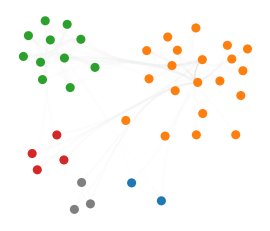

In [142]:
## display community detection outputs sample: from https://stackoverflow.com/questions/43541376/how-to-draw-communities-with-networkx

# create a modular graph
"""partition_sizes = [10, 20, 30, 40]
g = nx.random_partition_graph(partition_sizes, 0.5, 0.1)

# since we created the graph, we know the best partition:
node_to_community = dict()
node = 0
for community_id, size in enumerate(partition_sizes):
    for _ in range(size):
        node_to_community[node] = community_id
        node += 1

# # alternatively, we can infer the best partition using Louvain:
# from community import community_louvain"""
node_to_community = community_louvain.best_partition(G)

community_to_color = {
    0 : 'tab:blue',
    1 : 'tab:orange',
    2 : 'tab:green',
    3 : 'tab:red',
    4: 'tab:gray',
    5: 'tab:cyan'
}
node_color = {node: community_to_color[community_id] for node, community_id in node_to_community.items()}

Graph(G,
      node_color=node_color, node_edge_width=0, edge_alpha=0.1,
      node_layout='community', node_layout_kwargs=dict(node_to_community=node_to_community),
      edge_layout='bundled', edge_layout_kwargs=dict(k=2000),
)
plt.show()

In [144]:
node_to_community

{'Stanford University': 0,
 'United States National Science Foundation (NSF)': 0,
 'United States National Institutes of Health (NIH)': 1,
 'Open Society Foundations': 1,
 'United States Centers for Disease Control and Prevention (CDC)': 2,
 'Doris Duke Charitable Foundation (DDCF)': 1,
 'National Institute of Justice': 2,
 'US Department of Housing and Urban Development': 2,
 'Chicago Community Trust': 2,
 'Owen L. Coon Foundation': 2,
 'MacArthur Foundation': 2,
 'William T. Grant Foundation': 2,
 'Office of Juvenile Justice and Delinquency Prevention, US Department of Justice': 2,
 'United States Department of Health and Human Services (HHS)': 2,
 'Robert Wood Johnson Foundation': 2,
 'US Department of Labor': 2,
 'UCSD Center for AIDS Research (CFAR) (International Pilot)': 1,
 'Innovation+Design Enabling Access Initiative at the Johns Hopkins Bloomberg School of Public Health': 1,
 'UK Research and Innovation (UKRI)': 1,
 'Laura and John Arnold Foundation': 4,
 'U.S. Cancer Pain R

In [169]:
## use community detection to add group information to the output dict's node item
"""for f in funders:
    for dim in ["WoS Categories","Research Areas"]:
        for s in funderSubjDict[f][dim]['subjects']:
            G = nx.Graph()
            elist = [(x["source"],x["target"],x["value"]) for x in funderSubjStats[f][dim][s]['links']]
            G.add_weighted_edges_from(elist)
            # use louvain algorithm to detect communities
            node_to_community = community_louvain.best_partition(G)
            funderSubjStats[f][dim][s]['nodes'] = [{"id":k,"group":v} for k,v in node_to_community.items()]

            """

'for f in funders:\n    for dim in ["WoS Categories","Research Areas"]:\n        for s in funderSubjDict[f][dim][\'subjects\']:\n            G = nx.Graph()\n            elist = [(x["source"],x["target"],x["value"]) for x in funderSubjStats[f][dim][s][\'links\']]\n            G.add_weighted_edges_from(elist)\n            # use louvain algorithm to detect communities\n            node_to_community = community_louvain.best_partition(G)\n            funderSubjStats[f][dim][s][\'nodes\'] = [{"id":k,"group":v} for k,v in node_to_community.items()]\n\n            '

In [148]:
funderSubjStats["osf"]

{'WoS Categories': {'Medicine, General & Internal': {'top_cofunders': [{'funder': 'Open Society Foundations',
     'value': 86},
    {'funder': 'United States National Institutes of Health (NIH)',
     'value': 21},
    {'funder': 'UK Research and Innovation (UKRI)', 'value': 6},
    {'funder': 'Livestrong Foundation', 'value': 6},
    {'funder': 'Laura and John Arnold Foundation', 'value': 5},
    {'funder': 'United States Agency for International Development (USAID)',
     'value': 4},
    {'funder': 'Atlantic Philanthropies', 'value': 4},
    {'funder': 'Engelberg Foundation', 'value': 4},
    {'funder': 'United States Centers for Disease Control and Prevention (CDC)',
     'value': 3},
    {'funder': 'Harvard-MIT Center for Regulatory Science', 'value': 3},
    {'funder': 'United States Cancer Pain Relief Committee', 'value': 3},
    {'funder': 'United Nations Population Fund', 'value': 3},
    {'funder': 'Bill and Melinda Gates Foundation', 'value': 3},
    {'funder': 'South Afric

In [175]:
## quick check on how many community partitions are typically present...
for f in funders:
    community_nos = []
    for dim in ["WoS Categories","Research Areas"]:
        for s in funderSubjDict[f][dim]['subjects']:
            communities = [x['group'] for x in funderSubjStats[f][dim][s]['nodes']]
            community_nos.append(len(list(set(communities))))
    print(f,": ",Counter(community_nos))

rwj :  Counter({3: 10, 5: 10, 2: 8, 7: 8, 4: 7, 6: 5, 9: 2})
gates :  Counter({5: 18, 4: 15, 3: 7, 6: 5, 2: 4, 7: 1})
packard :  Counter({4: 17, 5: 13, 3: 7, 6: 6, 2: 4, 7: 2, 8: 1})
osf :  Counter({4: 20, 5: 12, 6: 9, 3: 3, 2: 3, 9: 1, 8: 1, 7: 1})
hewlett :  Counter({4: 17, 5: 13, 6: 9, 3: 7, 7: 3, 9: 1})
mellon :  Counter({6: 15, 5: 12, 4: 12, 2: 6, 3: 4, 8: 1})
ford :  Counter({5: 12, 6: 11, 7: 8, 3: 7, 4: 7, 2: 2, 8: 2, 10: 1})


## Ouput analytics assets

In [230]:
import pickle

In [231]:
pickle.dump( funderSubjStats, open( "funderSubjStats.p", "wb" ) )

In [232]:
with open('funderSubjStats.json', 'w') as outfile:
    json.dump(funderSubjStats, outfile)

In [233]:
## create separate files:
for f in funders:
    for dim in ["WoS Categories","Research Areas"]:
        with open("funder_subj_stats/"+f+"_"+dim+".json","w") as outfile:
            json.dump(funderSubjStats[f][dim],outfile)

## TO DO

In [ ]:
## num with grant numbers for each subject/funder and also at the broader funder aggregate level
## num funders in the cofunder list across grants for subject/funder and also at the broader level